# Spectogram classification 모델 구현
---
## 1차원 waveform을 2차원의 Spectrogram으로 변환 후 학습
- skip connection이 없는 기본 버전과 있는 버전을 비교

1. 데이터 처리와 분류
    - 라벨 데이터 처리하기
    - ```sklearn```의 ```train_test_split```함수를 이용하여 train, test 분리
2. 학습을 위한 하이퍼파라미터 과정
3. 데이터셋 구성
    - ```tf.data.Dataset```을 이용
    - from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플(data, label)형태로 넣어서 사용
    - map과 batch를 이용한 데이터 전처리
4. 2차원 Spectogram 데이터를 처리하는 모델 구성
    - 2차원 Spectogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
    - BatchNorm, Dropout, Dense layer 등을 이용
    - 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimzer를 사용
    - 모델 가중치를 저장하는 Checkpoint Callback 함수 추가
    - 다양한 모델의 실험을 진행해 본다
5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
    - loss, accuracy를 그래프로 표현
6. Test dataset을 이용해서 모델의 성능을 평가
    - 저장한 weight 불러오기
    - 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf
from tensorflow.keras import layers
from tqdm.notebook import tqdm

In [3]:
batch_size = 128
max_epochs = 50

### train data load

In [4]:
# data_path = os.getenv("HOME") + "/aiffel/speech_recognition/data/speech_wav_8000.npz"
data_path = '/content/drive/Shared drives/GOFOODA/DOS/wav/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [5]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [6]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  31764
Wave data shape :  (8000,)
label :  ['off']


### label data, one-hot encoding

In [7]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
label_value

{'down': 3,
 'go': 9,
 'left': 4,
 'no': 1,
 'off': 7,
 'on': 6,
 'right': 5,
 'silence': 11,
 'stop': 8,
 'unknown': 10,
 'up': 2,
 'yes': 0}

In [8]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
label_data, len(label_data)

(array([ 3,  3,  3, ..., 11, 11, 11]), 50620)

### train_test_split

In [35]:
from sklearn.model_selection import train_test_split

sr = 8000  # sampling rate
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

[[ 0.03029986  0.04931002  0.04492099 ...  0.05155573  0.04484221
   0.04081443]
 [ 0.00392983  0.00240466  0.00136524 ...  0.002612    0.00441726
   0.0009433 ]
 [-0.00030331 -0.00033063 -0.00010485 ...  0.00141877  0.00167597
   0.00154028]
 ...
 [ 0.00011348  0.00014947 -0.00043908 ... -0.00032227 -0.00029827
  -0.00049269]
 [ 0.00332952  0.00491187  0.0002012  ...  0.00232359  0.00190066
  -0.00199212]
 [-0.00145007 -0.00789316 -0.00783178 ...  0.00588391  0.00590851
   0.00533294]]


In [10]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)


### input data 변환
---
- 1차원의 waveform 데이터 -> 2차원의 Spectrogram으로 변환

In [11]:
def wav2spec(wave, n_fft=258, expand_channel = True) :
    result_spec = np.zeros((len(wave), 130, 126))
    
    
    for idx, wav in tqdm(enumerate(wave)):
        result_spec[idx] = np.abs(librosa.stft(wav, n_fft=n_fft))
    
    if expand_channel:
        return result_spec[:,:,:,np.newaxis]
    
    return result_spec

In [12]:
train_spec = wav2spec(train_wav)
test_spec = wav2spec(test_wav)
train_spec.shape, test_spec.shape

((45558, 130, 126, 1), (5062, 130, 126, 1))

In [13]:
train_wav_len = len(train_wav)
test_wav_len = len(test_wav)
del train_wav, test_wav

## tf.data API 활용

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
# train_ds = train_ds.map(mapping_wav2spec)
train_ds = train_ds.map(one_hot_label)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
# test_ds = test_ds.map(mapping_wav2spec)
test_ds = test_ds.map(one_hot_label)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(batch_size)


### Spectrogram 시각화

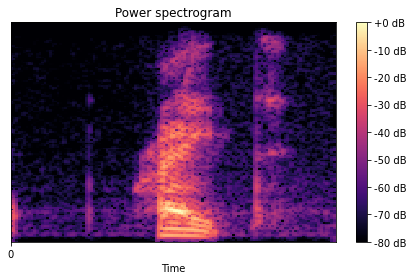

In [99]:
spectrogram = next(iter(train_ds))[0]

import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spectrogram[0,:,:,0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 모델 생성 및 학습

### callback함수 선언

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint('./model_nonskip.h5',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='auto', verbose=1)

### 모델 생성

In [17]:
def build_custom_model(is_skip=False):
    if is_skip :
        input_tensor = layers.Input(shape=(130, 126, 1))

        x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
        x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)

        x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)

        x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)

        x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        output_tensor = layers.Dense(12)(x)

        model = tf.keras.Model(input_tensor, output_tensor)
    
    else :

        input_tensor = layers.Input(shape=(130, 126, 1))

        x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
        x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
        skip_1 = layers.MaxPool2D()(x)

        x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
        x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
        x = tf.concat([x, skip_1], -1)
        skip_2 = layers.MaxPool2D()(x)

        x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
        x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
        x = tf.concat([x, skip_2], -1)
        skip_3 = layers.MaxPool2D()(x)

        x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
        x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
        x = tf.concat([x, skip_3], -1)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        output_tensor = layers.Dense(12)(x)

        model = tf.keras.Model(input_tensor, output_tensor)

    return model

In [26]:
model_wav = build_custom_model()
model_wav.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 130, 126, 32) 2624        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 65, 63, 32)   0           conv2d_31[0][0]                  
_______________________________________________________________________________________

In [28]:
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])
#30분 내외 소요
history_wav = model_wav.fit(train_ds, epochs=max_epochs,
                    steps_per_epoch=train_wav_len // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_wav_len // batch_size,
                    callbacks=[cp_callback, es]
                    )
model_wav.save('./normal_model.h5')
del model_wav

Epoch 1/50
355/355 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.6996
Epoch 00001: val_loss did not improve from 0.09071
355/355 [==============================] - 116s 327ms/step - loss: 0.9185 - accuracy: 0.6996 - val_loss: 0.4033 - val_accuracy: 0.8814
Epoch 2/50
355/355 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9221
Epoch 00002: val_loss did not improve from 0.09071
355/355 [==============================] - 116s 328ms/step - loss: 0.2409 - accuracy: 0.9221 - val_loss: 0.2307 - val_accuracy: 0.9237
Epoch 3/50
355/355 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9518
Epoch 00003: val_loss did not improve from 0.09071
355/355 [==============================] - 116s 328ms/step - loss: 0.1507 - accuracy: 0.9518 - val_loss: 0.1807 - val_accuracy: 0.9395
Epoch 4/50
355/355 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9640
Epoch 00004: val_loss did not improve from 0.09071
355/355

In [20]:
model_wav_skip = build_custom_model(is_skip=True)
model_wav_skip.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 31, 64)       

In [21]:
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

In [22]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_ds, epochs=max_epochs,
                    steps_per_epoch=train_wav_len // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_wav_len // batch_size,
                    callbacks=[cp_callback, es]
                    )
model_wav_skip.save('./skip_model.h5')
del model_wav_skip

Epoch 1/50
355/355 [==============================] - ETA: 0s - loss: 0.8408 - accuracy: 0.7172
Epoch 00001: val_loss did not improve from 0.10410
355/355 [==============================] - 109s 307ms/step - loss: 0.8408 - accuracy: 0.7172 - val_loss: 0.6797 - val_accuracy: 0.8828
Epoch 2/50
355/355 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.9156
Epoch 00002: val_loss did not improve from 0.10410
355/355 [==============================] - 108s 305ms/step - loss: 0.2642 - accuracy: 0.9156 - val_loss: 0.2201 - val_accuracy: 0.9301
Epoch 3/50
355/355 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9447
Epoch 00003: val_loss did not improve from 0.10410
355/355 [==============================] - 108s 305ms/step - loss: 0.1723 - accuracy: 0.9447 - val_loss: 0.1947 - val_accuracy: 0.9357
Epoch 4/50
355/355 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9571
Epoch 00004: val_loss did not improve from 0.10410
355/355

## 결과 시각화

In [80]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [94]:
print("Model :history_wav\nBest Validation Accuracy : {}".format(round(max(history_wav.history['val_accuracy']),4)))

Model :	history_wav
Best Validation Accuracy : 0.9667


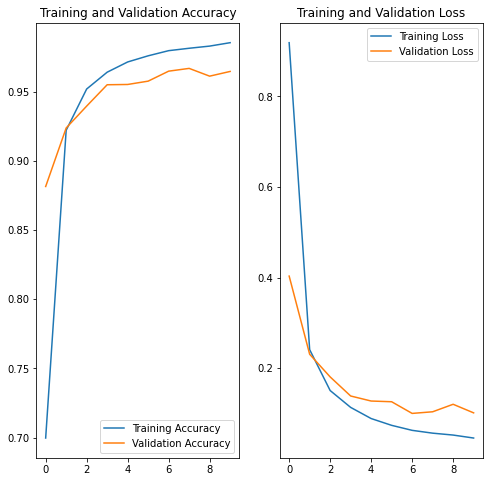

In [79]:
plot_result(history_wav)

In [95]:
print("Model : history_wav_skip\nBest Validation Accuracy : {}".format(round(max(history_wav_skip.history['val_accuracy']),4)))

Model :history_wav_skip
Best Validation Accuracy : 0.9716


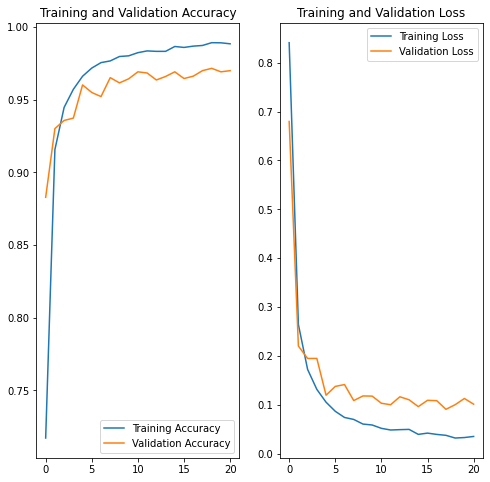

In [81]:
plot_result(history_wav_skip)

## Test

In [75]:
def spec2wav(spec, n_fft=258) :

    spec = spec.squeeze()
    wav = np.abs(librosa.istft(spec))
    
    return wav

In [37]:
model_wav = tf.keras.models.load_model('./normal_model.h5')

In [76]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))


ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  no


In [68]:
model_wav_skip = tf.keras.models.load_model('./skip_model.h5')

In [74]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))


ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  stop


In [98]:
next(iter(train_ds))[0].shape

TensorShape([128, 130, 126, 1])

# 정리
---
1. Spectrogram 시각화
    - 1차원의 waveform 데이터를 2차원의 Spectrogram으로 변환시켰다.  
        ![image](https://user-images.githubusercontent.com/48716219/98951535-b849a900-253d-11eb-8f67-bd838a5a1b45.png)

2. 두 가지 모델로 학습을 시켰다.
    - Skip Connection이 없는 모델
    - Skip Connection이 있는 모델
    - 두 모델의 accuracy는 각각 ```0.9667```, ```0.9716```으로 Skip Connection을 사용한 모델이 ```0.005```정도 더 정확하게 나왔다.

3. 학습 진행
    - Skip Connection 사용 X  
        ![image](https://user-images.githubusercontent.com/48716219/98952526-e8457c00-253e-11eb-8142-6db4176147de.png)
    - Skip Connection 사용  
        ![image](https://user-images.githubusercontent.com/48716219/98952636-06ab7780-253f-11eb-8b0e-9b17703612b9.png)

    - 기존의 1차원의 waveform을 학습시키던 모델의 Conv1D layer들을 Conv2D layer로 변경을 해주었다.
    - 모델에 데이터를 넣기 위해서 채널을 추가해주었다.
        ```python
        a.shape
        >>> (130, 126)
        a = a[:,:,np.newaxis]
        a.shape
        >>> (130, 126, 1)
        a = a.squeeze()
        a.shape
        >>> (130, 126)
        ```
    > 인위적으로 추가한 채널의 경우 ```np.squeeze```를 수행하여 채널의 차원을 없애고 ```Conv1D```로 학습해도 학습은 정상적으로 진행되었다.

